# TEST ANGULAR POWER SPECTRA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

In [2]:
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'legend.frameon': False,
    'legend.handlelength': 1.5,
})

In [3]:
TINY = np.finfo(0.).tiny

## 1. Load CosmoSIS quantities

* Metadata

In [4]:
nbin = 4
nbinl = 5

In [5]:
bin_a, bin_b = np.tril_indices(nbin)
bin_a += 1
bin_b += 1

In [6]:
binl_a, binl_b = np.tril_indices(nbinl)
binl_a += 1
binl_b += 1

In [7]:
bin_A = np.array([1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4])
binl_B = np.array([1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5])

* Cosmology

In [8]:
cosmo = {}
with open('des-y1-test/cosmological_parameters/values.txt') as cosmo_values:
    for line in cosmo_values:
        if line:
            key, val = line.partition('=')[::2]
            cosmo[key.strip()] = float(val)

In [9]:
cosmo_astropy = FlatLambdaCDM(H0=cosmo['hubble'], Ob0=cosmo['omega_b'], Om0= cosmo['omega_m'], Tcmb0=2.7)

* Distance functions

In [10]:
zdM = np.loadtxt('des-y1-test/distances/z.txt')
dM = np.loadtxt('des-y1-test/distances/d_m.txt')

* Matter power spectrum

In [11]:
zp = np.loadtxt('des-y1-test/matter_power_nl/z.txt')
k_h = np.loadtxt('des-y1-test/matter_power_nl/k_h.txt')
p_h = np.loadtxt('des-y1-test/matter_power_nl/p_k.txt')

In [12]:
xp = np.interp(zp, zdM, dM)

In [13]:
k0, kf = k_h[0]*(cosmo['hubble']/100), k_h[-1]*(cosmo['hubble']/100)

In [14]:
k_h2 = np.logspace(np.log10(k0), np.log10(kf), 2048)
p_h2 = np.exp([np.interp(np.log(k_h2), np.log(k_h), np.log(p)) for p in p_h])

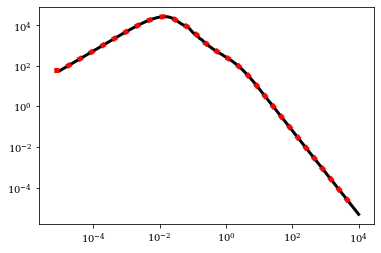

In [15]:
plt.loglog(k_h, p_h[0], '-k', lw=3)
plt.loglog(k_h2, p_h2[0], ':r', lw=5)
plt.show()

In [16]:
k = k_h2*cosmo['h0']
p = p_h2*cosmo['h0']**(-3)

In [17]:
p_geom = np.sqrt(p[:, None]*p[None, :])

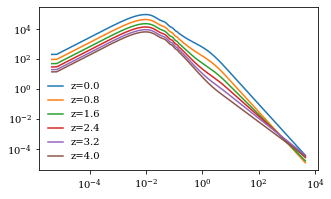

In [18]:
plt.figure(figsize=(5,3))
for z, pz in zip(zp[::20], p[::20]):
    plt.loglog(k, pz, label='z={}'.format(z))
plt.legend()
plt.show()

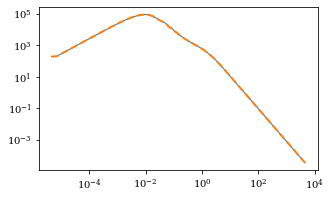

In [19]:
plt.figure(figsize=(5,3))
plt.loglog(k, p[0], lw=1)
plt.loglog(k, p_geom[0][0], '--',lw=2)
plt.show()

* Angula power spectrum

In [20]:
l_csis_ = np.loadtxt('des-y1-test/galaxy_shear_cl/ell.txt')
cl_csis_ = [np.loadtxt('des-y1-test/galaxy_shear_cl/bin_%d_%d.txt' % bins) for bins in zip(binl_B, bin_A)]

In [21]:
l_csis = np.arange(1, 100000.1, 1)
cl_csis = [np.interp(np.log(l_csis), np.log(l_csis_), cl) for cl in cl_csis_]

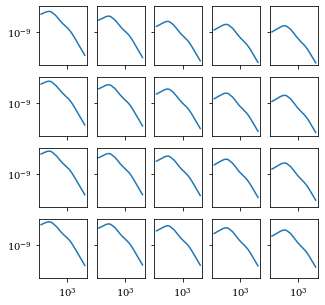

In [22]:
fig, axes = plt.subplots(4, 5, figsize=(5, 5), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_A, binl_B)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(l_csis, cl_csis[i])

# fig.tight_layout(pad=0.5)

plt.show()

## 2. The correlation function

In [23]:
import sys
sys.path.append("../../corfu")
import corfu

In [24]:
r_limb, xi_limb = corfu.ptoxi(k, p, q=0.0, limber=True)
r_geom, xi_geom = corfu.ptoxi(k, p_geom, q=0.0)

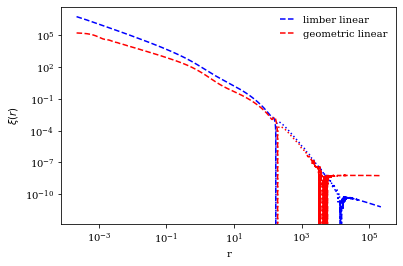

In [25]:
plt.figure(figsize=(6,4))
plt.loglog(r_limb, +xi_limb[0], '--b', label='limber linear')
plt.loglog(r_limb, -xi_limb[0], ':b')
plt.loglog(r_geom, +xi_geom[0,0], '--r', label='geometric linear')
plt.loglog(r_geom, -xi_geom[0,0], ':r')

plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.show()

## 3. Lensing filters

In [26]:
sys.path.append("../lensing")
from lens_filter import parametric_lensing_efficiency, redshift_distribution_galaxies, filter_galaxy_clustering, lensing_efficiency, filter_convergence, filter_shear

* Redshift distribution of galaxies

Source:

In [27]:
zn = np.loadtxt('des-y1-test/nz_source/z.txt')
nz = [np.loadtxt('des-y1-test/nz_source/bin_%d.txt' % i) for i in range(1, nbin+1)]

In [28]:
xf = np.interp(zn, zdM, dM)

Lensed:

In [29]:
nlz = [np.loadtxt('des-y1-test/nz_lens/bin_%d.txt' % i) for i in range(1, nbinl+1)]

* Lensing efficiency

In [30]:
q = [lensing_efficiency(xf, zn, n) for n in nz]

* Convergence

In [31]:
fc = [filter_convergence(xf, zn, qq, cosmo_astropy) for qq in q]

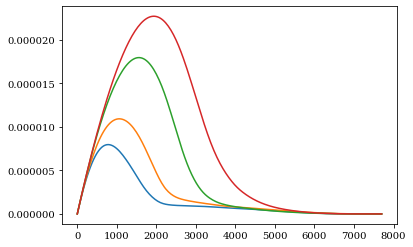

In [32]:
for qq in fc:
    plt.plot(xf, qq)
plt.show()

* Galaxy clustering

In [33]:
bias_LSST = [1.24, 1.36, 1.47, 1.60, 1.76]
bias_DESY1 = [1.44, 1.70, 1.70, 2.00, 2.06]
nobias = 1.0

In [34]:
fg = [filter_galaxy_clustering(xf, zn, n, bias_DESY1[0], cosmo_astropy) for n in nlz]

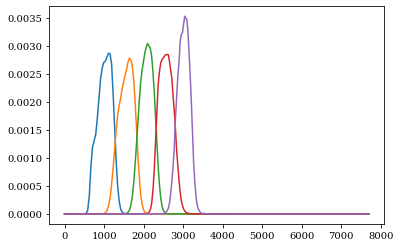

In [35]:
for qq in fg:
    plt.plot(xf, qq)
plt.show()

* Load CCL quantities

In [36]:
import pylab as plt
import pyccl as ccl

In [37]:
cosmocl = ccl.Cosmology(
    Omega_c=cosmo['omega_c'], Omega_b=cosmo['omega_b'], h=cosmo['h0'], sigma8=cosmo['sigma_8'], n_s=cosmo['n_s'],
    transfer_function='bbks')

In [38]:
bz = np.full(len(zn), bias_DESY1[0])

In [39]:
lens = [ccl.WeakLensingTracer(cosmocl, dndz=(zn, n)) for n in nz]
gal = [ccl.NumberCountsTracer(cosmocl, has_rsd=False, dndz=(zn, n), bias=(zn, bz)) for n in nlz]

In [40]:
ell = np.arange(0, 2000)
cls = [ccl.angular_cl(cosmocl, lens[a-1], gal[b-1], ell) for a, b in zip(bin_A, binl_B)]

## 4. Angular correlation function

In [41]:
theta = np.logspace(-3, np.log10(np.pi), 1024)
theta_arcmin = np.degrees(theta)*60

In [42]:
w_limb = [corfu.eqt(theta, (xf, fc[a-1]*fg[b-1]), (xp, r_limb, xi_limb)) for a, b in zip(bin_A, binl_B)]

In [44]:
w_geom = [corfu.uneqt(theta, (xf, fc[a-1]), (xf, fg[b-1]), (xp, xp, r_geom, xi_geom), True) for a, b in zip(bin_A, binl_B)]

100%|██████████| 349/349 [01:09<00:00,  5.02it/s]


In [43]:
w_csis = [corfu.cltow(cl, theta) for cl in cl_csis]

In [56]:
w_ccl = [corfu.cltow(cl, theta) for cl in cls]

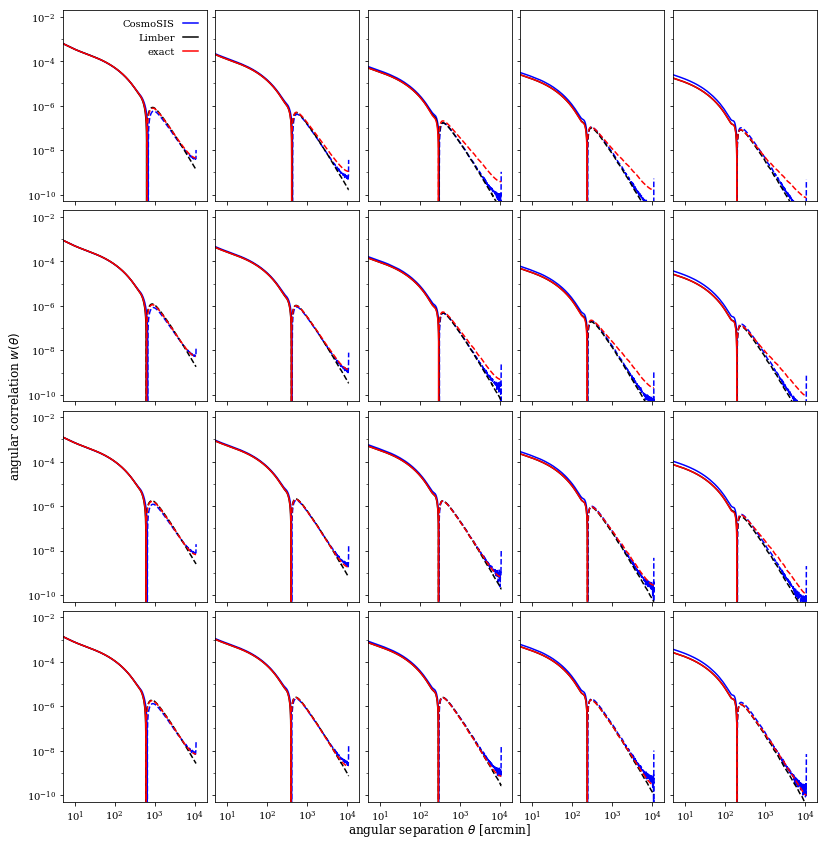

In [46]:
fig, axes = plt.subplots(4, 5, figsize=(12, 12), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_A, binl_B)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(theta_arcmin, +w_csis[i], 'b', label='CosmoSIS')
    ax.loglog(theta_arcmin, -w_csis[i], '--b')
#     ax.loglog(theta_arcmin, +w_ccl[i], 'c', label='CCL')
#     ax.loglog(theta_arcmin, -w_ccl[i], '--c')
    ax.loglog(theta_arcmin, +w_limb[i], 'k', label='Limber')
    ax.loglog(theta_arcmin, -w_limb[i], '--k')
    ax.loglog(theta_arcmin, +w_geom[i], 'r', label='exact')
    ax.loglog(theta_arcmin, -w_geom[i], '--r')
    ax.set_xlim(5e0, 2e4)
    ax.set_ylim(5e-11, 2e-2)
    ax.set_xticks([1e1, 1e2, 1e3, 1e4])
    ax.set_yticks([1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
    ax.set_yticks([1e-3, 1e-5, 1e-7, 1e-9], minor=True)
    ax.tick_params(axis='y', which='minor', labelcolor='none')

axes[0, 0].legend(markerfirst=False)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'angular separation $\theta$ [arcmin]', size=12)
ax.set_ylabel(r'angular correlation $w(\theta)$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=15)

fig.tight_layout(pad=0.5)

# fig.savefig('plots/w_GGL.pdf', bbox_inches='tight')

plt.show()


## 5. Angular power spectra

* Convergence

In [47]:
l_limb, cl_limb = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_limb], (1, 0, 2))

In [48]:
l_geom, cl_geom = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_geom], (1, 0, 2))

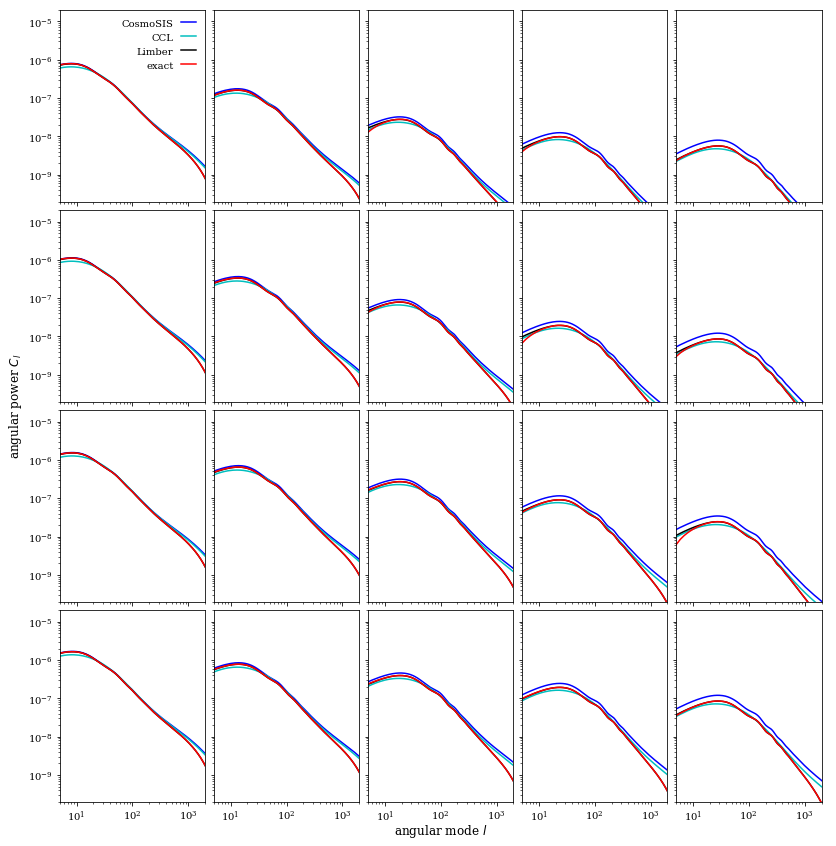

In [50]:
fig, axes = plt.subplots(4, 5, figsize=(12, 12), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_A, binl_B)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(l_csis, cl_csis[i], 'b', label='CosmoSIS')
    ax.loglog(cls[i], 'c', label='CCL')
    ax.loglog(l_limb[i], cl_limb[i], 'k', label='Limber')
    ax.loglog(l_geom[i], cl_geom[i], 'r', label='exact')
    ax.set_xlim(5e0, 2e3)
    ax.set_ylim(2e-10, 2e-5)
    ax.set_xticks([1e1, 1e2, 1e3])
#     ax.set_yticks([1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
#     ax.set_yticks([1e-3, 1e-5, 1e-7, 1e-9], minor=True)
#     ax.tick_params(axis='y', which='minor', labelcolor='none')

axes[0, 0].legend(markerfirst=False)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'angular mode $l$', size=12)
ax.set_ylabel(r'angular power $C_l$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)

fig.tight_layout(pad=0.5)

# fig.savefig('plots/cl_GGL.pdf', bbox_inches='tight')

plt.show()